# ❤️‍🩹🤖 제품 추천 모델

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 📌 데이터 불러오기
#individual_data: 개별 인정형
#nonindividual_data: 고시형
#symptom_data: 증상 데이터

In [52]:

individual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\individual_data_processed.xlsx')
nonindividual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\nonindividual_data_processed.xlsx')
symptom_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\symptom_final_data.xlsx')
# 개인형 & 비개인형 데이터 결합
individual_data['형태'] = '개별 인정형 품목'
nonindividual_data['형태'] = '고시형 품목'
combined_data = pd.concat([individual_data, nonindividual_data], ignore_index=True)


In [3]:
from transformers import AutoTokenizer, AutoModel

# 📌 모델 로드
model_name = "BM-K/KoSimCSE-roberta-multitask"
tokenizer = AutoTokenizer.from_pretrained(model_name)
symptom_model = AutoModel.from_pretrained(model_name)
warning_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

In [53]:
# 📌 증상-건강 카테고리 매핑 추가[자주 쓰이는 증상-카테고리 데이터 추가]
add_symptom_to_category = {
    "가슴이 답답하다": "심혈관 및 대사", "숨이 차다": "심혈관 및 대사","심장이 두근거린다": "심혈관 및 대사","혈압이 높다": "심혈관 및 대사",
 "손발이 차다": "심혈관 및 대사","당뇨가 있다": "심혈관 및 대사","살이 많이 찐다": "심혈관 및 대사", "비만이 걱정된다": "심혈관 및 대사",
"고혈당이 있다": "심혈관 및 대사", "속이 메스껍다": "간 및 소화","속이 쓰리다": "간 및 소화","가스가 자주 찬다": "간 및 소화","소화가 잘 안된다": "간 및 소화",
"소변 색이 짙다": "간 및 소화","변비가 있다": "간 및 소화","설사를 자주 한다": "간 및 소화","복부팽만감이 있다": "간 및 소화","감기에 자주 걸린다": "면역 및 체력","몸이 쉽게 피곤하다": "면역 및 체력", 
"콧물이 난다.": "면역 및 체력","기운이 없다": "면역 및 체력","너무 춥다.": "면역 및 체력","근육통이 있다": "면역 및 체력","면역력이 약하다": "면역 및 체력","잠을 잘 못 잔다": "수면 및 정신",
"스트레스를 많이 받는다": "수면 및 정신","우울감을 느낀다": "수면 및 정신","불안하다": "수면 및 정신","집중력이 떨어진다": "수면 및 정신", "무릎이 아프다": "뼈 및 구조",
"허리가 아프다": "뼈 및 구조","관절이 뻣뻣하다": "뼈 및 구조","골다공증이 걱정된다": "뼈 및 구조","등이 결린다": "뼈 및 구조"
}

# 증상 데이터에 추가
symptom_df = pd.DataFrame(list(add_symptom_to_category.items()), columns=['text', '건강 카테고리'])
symptom_data = pd.concat([symptom_data, symptom_df], ignore_index=True)


In [54]:
# 🔧 문장을 SBERT 벡터로 변환하는 함수 (Mean Pooling 적용)
def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = symptom_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# 📌 SBERT 벡터화
symptom_vectors = np.array([encode_text(text) for text in symptom_data['text']])
# 📌 라벨 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(symptom_data['건강 카테고리'])

# 🚨 SMOTE 적용
smote = SMOTE(sampling_strategy='auto', random_state=42)  
X_resampled, y_resampled = smote.fit_resample(symptom_vectors, encoded_labels)
# 🚨 train-test split 수정: stratify를 올바르게 설정
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [55]:
# 모델 학습 시 과적합 방지를 위한 하이퍼파라미터 조정
from xgboost import XGBClassifier

# ✅ XGBoost 모델 생성 (eval_metric과 early_stopping_rounds를 생성자에서 설정)
model = XGBClassifier(
    n_estimators=500, 
    learning_rate=0.01, 
    max_depth=4, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    eval_metric="mlogloss",  # 다중 분류 설정
    early_stopping_rounds=50, 
    random_state=42
)
# ✅ 모델 학습
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True)

# ✅ 예측 수행
y_pred = model.predict(X_test)

[0]	validation_0-mlogloss:1.77655
[1]	validation_0-mlogloss:1.76193
[2]	validation_0-mlogloss:1.74907
[3]	validation_0-mlogloss:1.73374
[4]	validation_0-mlogloss:1.71949
[5]	validation_0-mlogloss:1.70653
[6]	validation_0-mlogloss:1.69324
[7]	validation_0-mlogloss:1.68113
[8]	validation_0-mlogloss:1.66870
[9]	validation_0-mlogloss:1.65674
[10]	validation_0-mlogloss:1.64410
[11]	validation_0-mlogloss:1.63183
[12]	validation_0-mlogloss:1.62097
[13]	validation_0-mlogloss:1.60908
[14]	validation_0-mlogloss:1.59698
[15]	validation_0-mlogloss:1.58628
[16]	validation_0-mlogloss:1.57486
[17]	validation_0-mlogloss:1.56248
[18]	validation_0-mlogloss:1.55160
[19]	validation_0-mlogloss:1.54015
[20]	validation_0-mlogloss:1.52898
[21]	validation_0-mlogloss:1.51802
[22]	validation_0-mlogloss:1.50829
[23]	validation_0-mlogloss:1.49733
[24]	validation_0-mlogloss:1.48694
[25]	validation_0-mlogloss:1.47770
[26]	validation_0-mlogloss:1.46907
[27]	validation_0-mlogloss:1.46019
[28]	validation_0-mlogloss:1.4

📈 모델 정확도: 0.8030
📊 Validation 데이터 정확도: 0.8333
              precision    recall  f1-score   support

      간 및 소화       0.91      0.91      0.91        11
          기타       0.92      1.00      0.96        11
     면역 및 체력       0.78      0.64      0.70        11
      뼈 및 구조       0.80      0.73      0.76        11
     수면 및 정신       0.82      0.82      0.82        11
    심혈관 및 대사       0.77      0.91      0.83        11

    accuracy                           0.83        66
   macro avg       0.83      0.83      0.83        66
weighted avg       0.83      0.83      0.83        66

📈 Test 데이터 정확도: 0.8030
              precision    recall  f1-score   support

      간 및 소화       0.90      0.82      0.86        11
          기타       0.92      1.00      0.96        11
     면역 및 체력       0.80      0.73      0.76        11
      뼈 및 구조       0.92      1.00      0.96        11
     수면 및 정신       0.86      0.55      0.67        11
    심혈관 및 대사       0.53      0.73      0.62        11

    accu

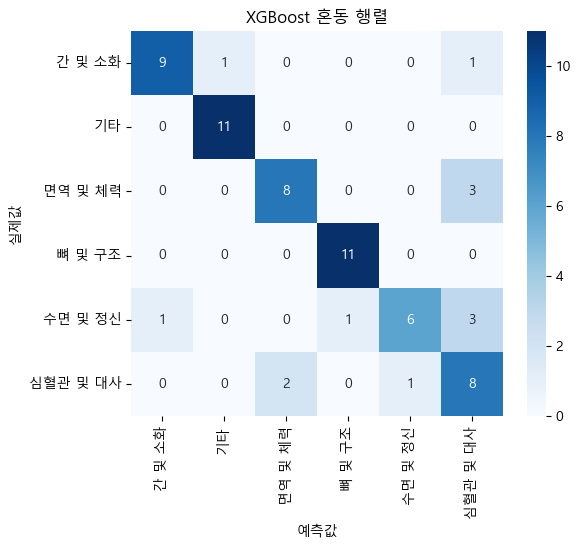

In [56]:
# ✅ 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"📈 모델 정확도: {accuracy:.4f}")

# 📌 Validation 평가
y_valid_pred = model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"📊 Validation 데이터 정확도: {valid_accuracy:.4f}")
print(classification_report(y_valid, y_valid_pred, target_names=label_encoder.classes_))

# 📌 Test 평가
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"📈 Test 데이터 정확도: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


# 정밀도, 재현율, F1-score 출력
print("\n📊 분류 성능 보고서:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("XGBoost 혼동 행렬")
plt.show()


# 🛰️제품 추천 및 지병 및 특이사항 필터링 함수(모델 사용)
    

In [71]:
  # 📌 지병 및 특이사항 필터링 함수
def is_safe_for_condition(product_warning, user_condition, threshold=0.45):
    if isinstance(product_warning, float) and pd.isna(product_warning):
        return True
    bullets = product_warning.split('\n')
    for bullet in bullets:
        bullet = bullet.strip()
        if bullet == "섭취 주의사항":
            continue
        sim = util.cos_sim(warning_model.encode(bullet).reshape(1, -1), warning_model.encode(user_condition).reshape(1, -1))[0][0].item()
        if sim >= threshold:
            return False
    return True

# 📌 제품 추천 함수 
def recommend_health_products(user_input, user_condition, top_n=2):
    input_vector = encode_text(user_input).reshape(1, -1)
    
   # 증상과 가장 유사한 건강 카테고리 예측
    symptom_similarities = [
        (util.cos_sim(input_vector, encode_text(row['text']).reshape(1, -1))[0][0].item(), row['건강 카테고리']) 
        for _, row in symptom_data.iterrows()
    ]
    max_similarity = max(symptom_similarities, key=lambda x: x[0])
    content = max_similarity[0]  # 유사도 값
    predicted_category = max_similarity[1]  # 카테고리
    content=str(content)
    
    # 추천 제품 필터링 
    recommended_products = [
        (row['품목명'],row['주요 기능'], row['종류'], row['건강 카테고리'])
        for _, row in combined_data.iterrows() 
        if row['건강 카테고리'] == predicted_category
        and is_safe_for_condition(row['섭취 주의사항'], user_condition)
    ]

    # 사용자가 입력한 증상과 '주요 기능'의 유사도를 계산하여 가장 유사한 top_n개 제품 선택
    product_similarities = []
    for product in recommended_products:
        product_name, product_func, product_kind, product_category = product
        if product_func:  # '주요 기능'이 비어있지 않으면 유사도 계산
            feature_similarity = util.cos_sim(encode_text(user_input), encode_text(product_func)).item()
            product_similarities.append((product_name, product_kind, feature_similarity))
    
    # '주요 기능'과 유사도가 높은 순으로 정렬하고, 2개 추출
    product_similarities = sorted(product_similarities, key=lambda x: x[2], reverse=True)[:top_n]
    
    # 추천할 제품이 없으면 메시지 출력 후 종료
    if not product_similarities:
        print("\n⚠ 추천할 제품이 없습니다.")
        return

    print(f"\n🧠 예측된 건강 카테고리: {predicted_category}")
    print(f"💊 최종 추천 건강기능식품:")

    # 오류 방지를 위해 개수 확인 후 출력
    for idx, item in enumerate(product_similarities):
            name, kind, sim = item
            print(f"{idx+1}. {name} ({kind})")
            

#  🥗 예제 실행

In [74]:
user_input = "눈이 건조해요"
user_condition = "임산부"
recommend_health_products(user_input, user_condition, top_n=2)


🧠 예측된 건강 카테고리: 면역 및 체력
💊 최종 추천 건강기능식품:
1. 빌베리 추출물 (고시형)
2. Enterococcus faecalis 가열처리건조분말(제2008-31호) (고시형)
